In [1]:
from pathlib import Path
import time
import random
import io
from time import time
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn.metrics as metrics
import torchvision
from torchvision.utils import make_grid
import torchvision.models as models
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
import numpy as np
import pandas as pd
import pickle

from torch.utils.data import random_split
from torch.utils.data.dataloader import DataLoader
import torch.nn as nn
import torch.nn.functional as F


from torchvision.models import  resnet50, ResNet50_Weights
from PIL import Image
from torch.optim import Adam
import torch.optim as optim
from torch.nn import Linear, CrossEntropyLoss
import copy
from tqdm import tqdm

In [2]:
import torch
from torch import nn

# Note: this notebook requires torch >= 1.10.0
torch.__version__

'2.0.1+cpu'

In [3]:
# Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

## Get data

In [47]:
import os
from collections import defaultdict

def count_images(data_dir):
    class_counts = defaultdict(lambda: {'train': 0, 'test': 0})

    for phase in ['train', 'test']:
        phase_dir = os.path.join(data_dir, phase)
        if not os.path.isdir(phase_dir):
            print(f"{phase_dir} is not a directory")
            continue

        for class_name in os.listdir(phase_dir):
            class_dir = os.path.join(phase_dir, class_name)
            if not os.path.isdir(class_dir):
                continue

            num_images = len([f for f in os.listdir(class_dir) if os.path.isfile(os.path.join(class_dir, f))])
            class_counts[class_name][phase] += num_images

    return class_counts

data_dir = 'Food Images\pizza_steak_sushi'  # Replace with your dataset directory
class_counts = count_images(data_dir)

for class_name, counts in class_counts.items():
    print(f"Class: {class_name}")
    print(f"  Train: {counts['train']} images")
    print(f"  Test: {counts['test']} images")


Class: pizza
  Train: 79 images
  Test: 25 images
Class: steak
  Train: 75 images
  Test: 19 images
Class: sushi
  Train: 72 images
  Test: 31 images


In [5]:

# Setup train and testing paths
train_dir = Path("Food Images/pizza_steak_sushi/train")
test_dir = Path("Food Images/pizza_steak_sushi/test")

train_dir, test_dir


(WindowsPath('Food Images/pizza_steak_sushi/train'),
 WindowsPath('Food Images/pizza_steak_sushi/test'))

### datasetup || Going modular
#### see this link : https://www.learnpytorch.io/05_pytorch_going_modular/

In [8]:
# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine

c:\Users\s21\Desktop\my data\Computer Vision\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### Tranform data  Manually

In [9]:
# Create a transforms pipeline manually (required for torchvision < 0.13)
manual_transforms = transforms.Compose([
    transforms.Resize((224, 224)), # 1. Reshape all images to 224x224 (though some models may require different sizes)
    transforms.ToTensor(), # 2. Turn image values to between 0 & 1
    transforms.Normalize(mean=[0.485, 0.456, 0.406], # 3. A mean of [0.485, 0.456, 0.406] (across each colour channel)
                         std=[0.229, 0.224, 0.225]) # 4. A standard deviation of [0.229, 0.224, 0.225] (across each colour channel),
])

#### Data loader from data_setup.py

##### Note : here we manually transforming data.

In [10]:
from going_modular.going_modular import data_setup, engine

# Create training and testing DataLoaders as well as get a list of class names
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=manual_transforms, # resize, convert images to between 0 & 1 and normalize them
                                                                               batch_size=32) # set mini-batch size to 32

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x2364def5f50>,
 ['pizza', 'steak', 'sushi'])

### Creating data loaders using pretrained model transform method (same transform method, which original model is used)
#### As previously stated, when using a pretrained model, it's important that your custom data going into the model is prepared in the same way as the original training data that went into the model.

Above we saw how to manually create a transform for a pretrained model.

But as of torchvision v0.13+, an automatic transform creation feature has been added.

In [11]:
# Get a set of pretrained model weights
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # .DEFAULT = best available weights from pretraining on ImageNet
weights

EfficientNet_B0_Weights.IMAGENET1K_V1

And now to access the transforms assosciated with our weights, we can use the transforms() method.

This is essentially saying "get the data transforms that were used to train the EfficientNet_B0_Weights on ImageNet".

In [12]:
# Get the transforms used to create our pretrained weights
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

#### Note : The benefit of automatically creating a transform through weights.transforms() is that you ensure you're using the same data transformation as the pretrained model used when it was trained.

In [13]:
# Create training and testing DataLoaders as well as get a list of class names
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=auto_transforms, # perform same data transforms on our own data as the pretrained model
                                                                               batch_size=32) # set mini-batch size to 32

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x2364df0dcd0>,
 ['pizza', 'steak', 'sushi'])

### Getting a pretrained model

#### Exploring the documentation, you'll find plenty of common computer vision architecture backbones such as:

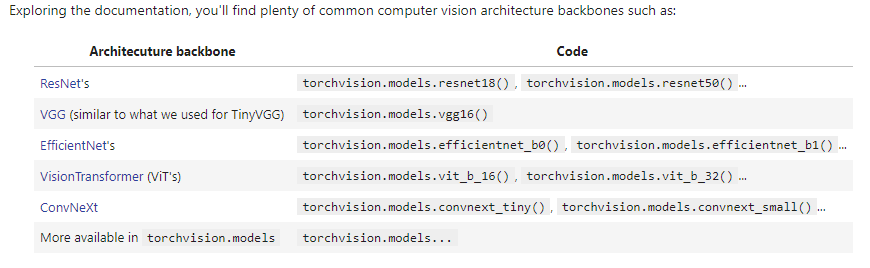

In [14]:
# OLD: Setup the model with pretrained weights and send it to the target device (this was prior to torchvision v0.13)
# model = torchvision.models.efficientnet_b0(pretrained=True).to(device) # OLD method (with pretrained=True)

# NEW: Setup the model with pretrained weights and send it to the target device (torchvision v0.13+)
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # .DEFAULT = best available weights
model = torchvision.models.efficientnet_b0(weights=weights).to(device)

model # uncomment to output (it's very long)

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

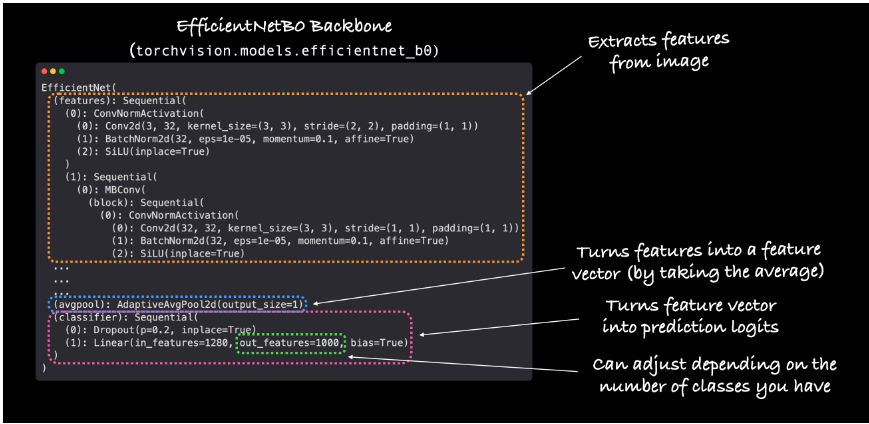

#### efficientnet_b0 is pretrained on ImageNet and because ImageNet has 1000 classes, out_features=1000 is the default).

### Getting a summary of our model with torchinfo.summary()

To learn more about our model, let's use torchinfo's summary() method.

To do so, we'll pass in:

model - the model we'd like to get a summary of.

input_size - the shape of the data we'd like to pass to our model, for the case of efficientnet_b0, the input size is (batch_size, 3, 224, 224), though other variants of efficientnet_bX have different input sizes.

Note: Many modern models can handle input images of varying sizes thanks to torch.nn.AdaptiveAvgPool2d(), this layer adaptively adjusts the output_size of a given input as required. You can try this out by passing different size input images to summary() or your models.

col_names - the various information columns we'd like to see about our model.

col_width - how wide the columns should be for the summary.

row_settings - what features to show in a row.

In [17]:
# Print a summary using torchinfo (uncomment for actual output)

from torchinfo import summary


summary(model=model,
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 1000]           --                   True
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   864                  True
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   64                   True
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 16, 112

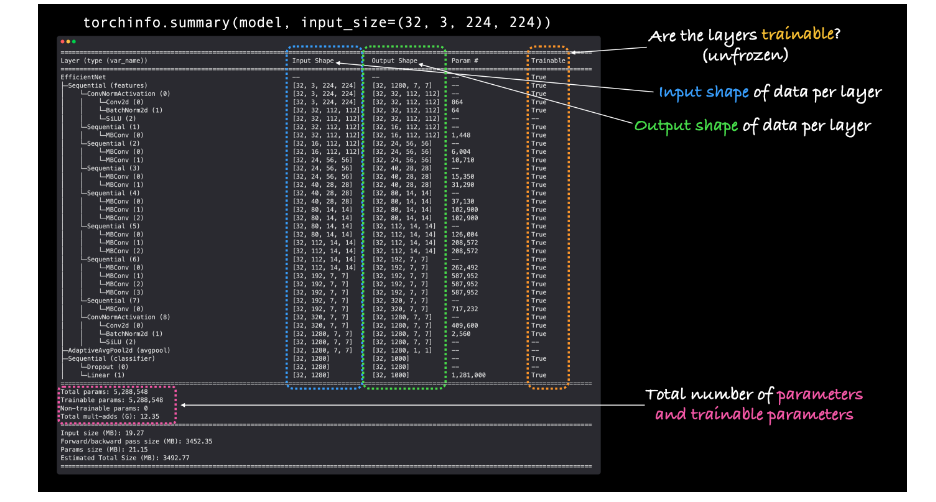

### Freezing the base model and changing the output layer to suit our needs
The process of transfer learning usually goes: freeze some base layers of a pretrained model (typically the features section) and then adjust the output layers (also called head/classifier layers) to suit your needs.

changing the efficientnet classifier head to a custom number of outputs
You can customise the outputs of a pretrained model by changing the output layer(s) to suit your problem. The original torchvision.models.efficientnet_b0() comes with out_features=1000 because there are 1000 classes in ImageNet, the dataset it was trained on. However, for our problem, classifying images of pizza, steak and sushi we only need out_features=3.

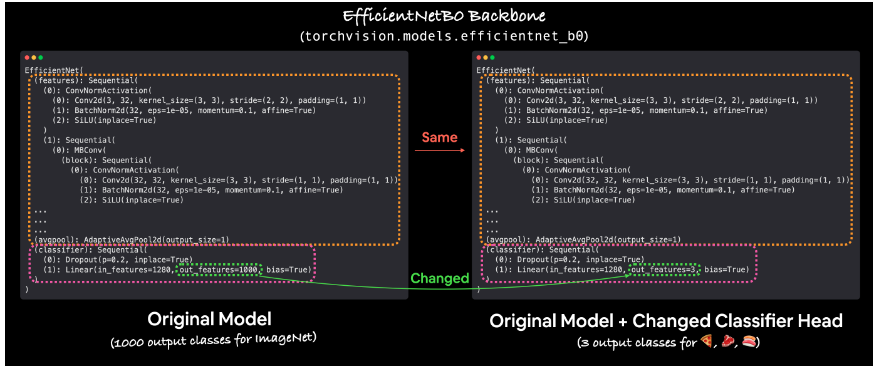

#### Let's freeze all of the layers/parameters in the features section of our efficientnet_b0 model.

Note: To freeze layers means to keep them how they are during training. For example, if your model has pretrained layers, to freeze them would be to say, "don't change any of the patterns in these layers during training, keep them how they are." In essence, we'd like to keep the pretrained weights/patterns our model has learned from ImageNet as a backbone and then only change the output layers.

We can freeze all of the layers/parameters in the features section by setting the attribute requires_grad=False.

For parameters with requires_grad=False, PyTorch doesn't track gradient updates and in turn, these parameters won't be changed by our optimizer during training.

In essence, a parameter with requires_grad=False is "untrainable" or "frozen" in place.

In [18]:
# Freeze all base layers in the "features" section of the model (the feature extractor) by setting requires_grad=False
for param in model.features.parameters():
    param.requires_grad = False

#### Let's now adjust the output layer or the classifier portion of our pretrained model to our needs.

Right now our pretrained model has out_features=1000 because there are 1000 classes in ImageNet.

However, we don't have 1000 classes, we only have three, pizza, steak and sushi.

We can change the classifier portion of our model by creating a new series of layers.

The current classifier consists of:

(classifier): Sequential(
    (0): Dropout(p=0.2, inplace=True)
    (1): Linear(in_features=1280, out_features=1000, bias=True)
We'll keep the Dropout layer the same using torch.nn.Dropout(p=0.2, inplace=True).

Note: Dropout layers randomly remove connections between two neural network layers with a probability of p. For example, if p=0.2, 20% of connections between neural network layers will be removed at random each pass. This practice is meant to help regularize (prevent overfitting) a model by making sure the connections that remain learn features to compensate for the removal of the other connections (hopefully these remaining features are more general).

And we'll keep in_features=1280 for our Linear output layer but we'll change the out_features value to the length of our class_names (len(['pizza', 'steak', 'sushi']) = 3).

Our new classifier layer should be on the same device as our model.

In [19]:
# Set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Get the length of class_names (one output unit for each class)
output_shape = len(class_names)

# Recreate the classifier layer and seed it to the target device
model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(in_features=1280,
                    out_features=output_shape, # same number of output units as our number of classes
                    bias=True)).to(device)

#### Output layer updated, let's get another summary of our model and see what's changed.

In [20]:
# # Do a summary *after* freezing the features and changing the output classifier layer (uncomment for actual output)
summary(model,
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape" (batch_size, color_channels, height, width)
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

### Train model

In [21]:
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [60]:
import torch
from timeit import default_timer as timer

def train_model(engine, model, train_dataloader, test_dataloader, optimizer, loss_fn, device, epochs):
    """
    Train the model and return the results.
    
    Args:
        engine: Training engine object.
        model: The model to be trained.
        train_dataloader: DataLoader for training data.
        test_dataloader: DataLoader for testing data.
        optimizer: Optimizer for the training.
        loss_fn: Loss function to use.
        device: Device to train on (CPU or GPU).
        epochs: Number of epochs to train.
        seed: Random seed for reproducibility.
    
    Returns:
        results: Training results.
    """
    
    # Set the random seeds for reproducibility
    torch.manual_seed(42)
    torch.cuda.manual_seed(42)

    # Start the timer
    start_time = timer()

    # Setup training and save the results
    results = engine.train(model=model,
                           train_dataloader=train_dataloader,
                           test_dataloader=test_dataloader,
                           optimizer=optimizer,
                           loss_fn=loss_fn,
                           epochs=epochs,
                           device=device)

    # End the timer and print out how long it took
    end_time = timer()
    print(f"[INFO] Total training time: {end_time - start_time:.3f} seconds")
    
    return results


In [49]:
results = train_model(engine,
                      model,
                      train_dataloader,
                      test_dataloader,
                      optimizer,
                      loss_fn,
                      device,
                      epochs=5)


 20%|██        | 1/5 [00:18<01:12, 18.24s/it]

Epoch: 1 | train_loss: 0.5398 | train_acc: 0.9180 | test_loss: 0.5514 | test_acc: 0.8864


 40%|████      | 2/5 [00:36<00:54, 18.07s/it]

Epoch: 2 | train_loss: 0.5155 | train_acc: 0.9297 | test_loss: 0.5343 | test_acc: 0.8665


 60%|██████    | 3/5 [00:55<00:37, 18.82s/it]

Epoch: 3 | train_loss: 0.4519 | train_acc: 0.9258 | test_loss: 0.4896 | test_acc: 0.8561


 80%|████████  | 4/5 [01:15<00:19, 19.30s/it]

Epoch: 4 | train_loss: 0.4659 | train_acc: 0.9258 | test_loss: 0.4618 | test_acc: 0.8864


100%|██████████| 5/5 [01:35<00:00, 19.17s/it]

Epoch: 5 | train_loss: 0.4170 | train_acc: 0.9570 | test_loss: 0.4903 | test_acc: 0.8258
[INFO] Total training time: 95.865 seconds


In [23]:
results

{'train_loss': [1.0965989530086517,
  0.9192044138908386,
  0.7541996985673904,
  0.7377770990133286,
  0.6267921887338161],
 'train_acc': [0.38671875, 0.65234375, 0.87109375, 0.7109375, 0.76171875],
 'test_loss': [0.8842612306276957,
  0.7913958430290222,
  0.6483494440714518,
  0.5965305964152018,
  0.6126677393913269],
 'test_acc': [0.6827651515151515,
  0.8257575757575758,
  0.9166666666666666,
  0.8958333333333334,
  0.8967803030303031]}

#### plots

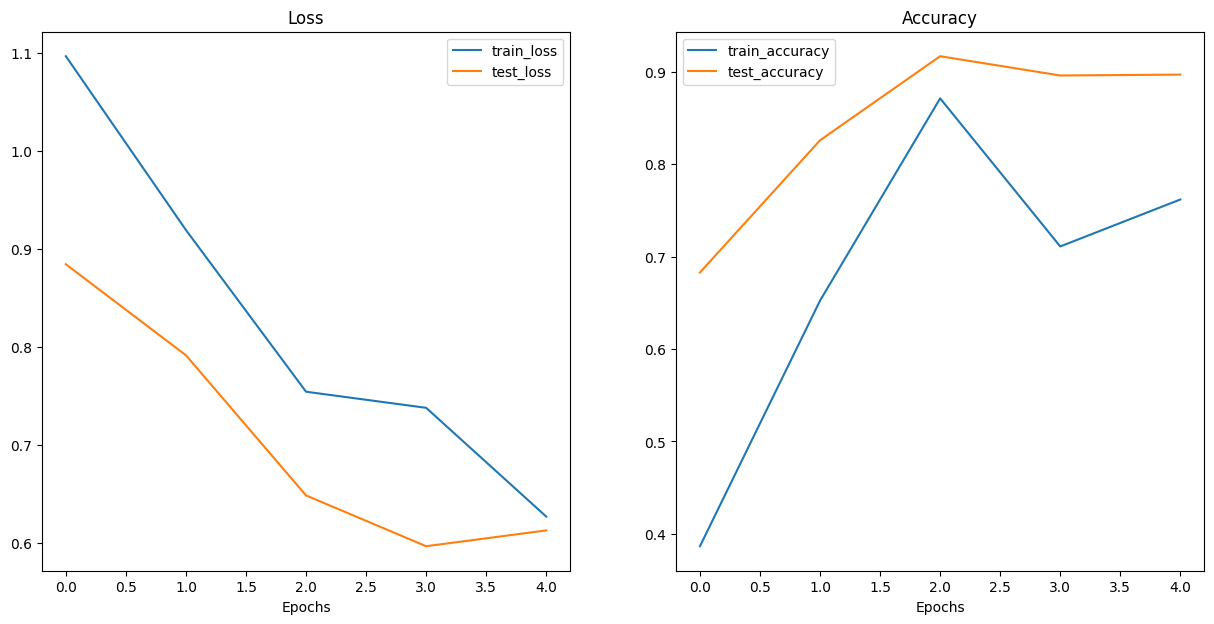

In [24]:
from typing import Dict, List



def plot_loss_curves(results: Dict[str, List[float]]):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """

    # Get the loss values of the results dictionary (training and test)
    loss = results['train_loss']
    test_loss = results['test_loss']

    # Get the accuracy values of the results dictionary (training and test)
    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    # Setup a plot
    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();


plot_loss_curves(results)

#### Or u can also plot like this


[INFO] Couldn't find helper_functions.py, downloading...


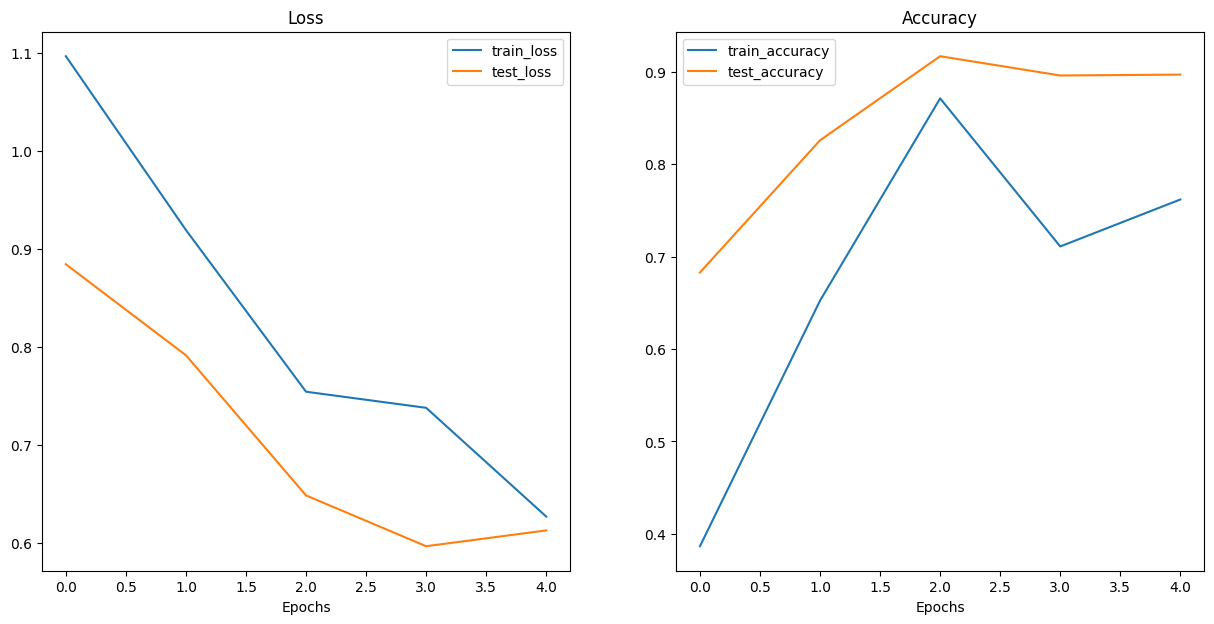

In [25]:
# Get the plot_loss_curves() function from helper_functions.py, download the file if we don't have it
try:
    from helper_functions import plot_loss_curves
except:
    print("[INFO] Couldn't find helper_functions.py, downloading...")
    with open("helper_functions.py", "wb") as f:
        import requests
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
        f.write(request.content)
    from helper_functions import plot_loss_curves

# Plot the loss curves of our model
plot_loss_curves(results)

### Save the Model and :Load the model

In [51]:


def save_model(model, save_path):
    """
    Save the model's state dictionary to a .pth file.
    
    Args:
        model: The model to be saved.
        save_path: File path where the model will be saved.
    """
    torch.save(model.state_dict(), save_path)
    print(f"Model saved to {save_path}")

def load_model(model, load_path):
    """
    Load the model's state dictionary from a .pth file.
    
    Args:
        model: The model to load the state dictionary into.
        load_path: File path from which to load the model.
    """
    model.load_state_dict(torch.load(load_path))
    print(f"Model loaded from {load_path}")


model_save_path = "model_finetunned_efficientnet.pth"
model_load_path = "model_finetunned_efficientnet.pth"

# Assuming `model` is defined elsewhere in your code
save_model(model, model_save_path)
load_model(model, model_load_path)


Model saved to model_finetunned_efficientnet.pth
Model loaded from model_finetunned_efficientnet.pth


### Make a prediction on a test images

#### One thing we'll have to remember is that for our model to make predictions on an image, the image has to be in same format as the images our model was trained on.

This means we'll need to make sure our images have:

Same shape - If our images are different shapes to what our model was trained on, we'll get shape errors.

Same datatype - If our images are a different datatype (e.g. torch.int8 vs. torch.float32) we'll get datatype errors.

Same device - If our images are on a different device to our model, we'll get device errors..

Same transformations - If our model is trained on images that have been transformed in certain way (e.g. normalized with a specific mean and standard deviation) and we try and make preidctions on images transformed in a different way, these predictions may be off.

Note: These requirements go for all kinds of data if you're trying to make predictions with a trained model. Data you'd like to predict on should be in the same format as your model was trained on.

In [30]:
from typing import List, Tuple

from PIL import Image

# 1. Take in a trained model, class names, image path, image size, a transform and target device
def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str,
                        class_names: List[str],
                        image_size: Tuple[int, int] = (224, 224),
                        transform: torchvision.transforms = None,
                        device: torch.device=device):


    # 2. Open image
    img = Image.open(image_path)

    # 3. Create transformation for image (if one doesn't exist)
    if transform is not None:
        image_transform = transform
    else:
        image_transform = transforms.Compose([
            transforms.Resize(image_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]),
        ])

    ### Predict on image ###

    # 4. Make sure the model is on the target device
    model.to(device)

    # 5. Turn on model evaluation mode and inference mode
    model.eval()
    with torch.inference_mode():
      # 6. Transform and add an extra dimension to image (model requires samples in [batch_size, color_channels, height, width])
      transformed_image = image_transform(img).unsqueeze(dim=0)

      # 7. Make a prediction on image with an extra dimension and send it to the target device
      target_image_pred = model(transformed_image.to(device))

    # 8. Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # 9. Convert prediction probabilities -> prediction labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    # 10. Plot image with predicted label and probability
    plt.figure()
    plt.imshow(img)
    plt.title(f"Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.max():.3f}")
    plt.axis(False);

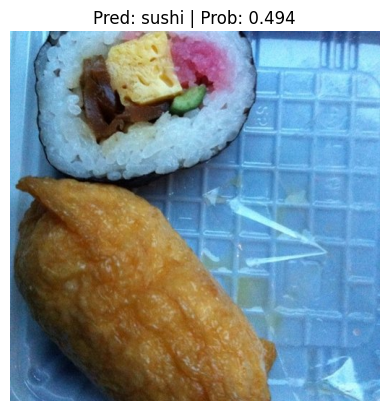

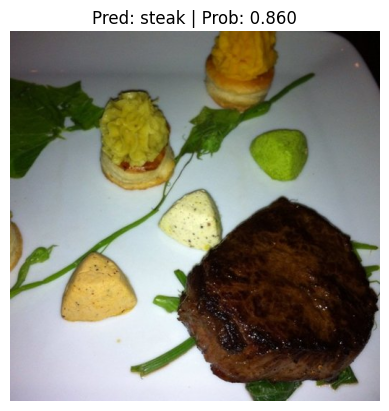

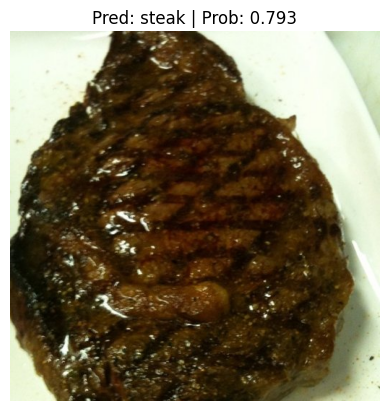

In [31]:
# Get a random list of image paths from test set
import random
num_images_to_plot = 3
test_image_path_list = list(Path(test_dir).glob("*/*.jpg")) # get list all image paths from test data
test_image_path_sample = random.sample(population=test_image_path_list, # go through all of the test image paths
                                       k=num_images_to_plot) # randomly select 'k' image paths to pred and plot

# Make predictions on and plot the images
for image_path in test_image_path_sample:
    pred_and_plot_image(model=model,
                        image_path=image_path,
                        class_names=class_names,
                        # transform=weights.transforms(), # optionally pass in a specified transform from our pretrained model weights
                        image_size=(224, 224))

### Making predictions on a custom or unseen image

#### 1. I am predicting on pizza image, let see model prediction

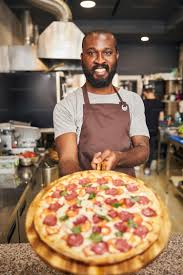

In [36]:
from PIL import Image
img_path=r"Food Images\pizza_steak_sushi\pizza2.jpg"
img_pizza=Image.open(img_path)
img_pizza

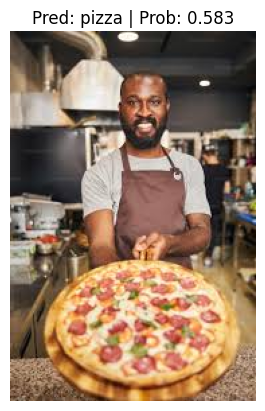

In [37]:
pred_and_plot_image(model=model,
                        image_path=img_path,
                        class_names=class_names,
                        # transform=weights.transforms(), # optionally pass in a specified transform from our pretrained model weights
                        image_size=(224, 224))

 Note; We given Pizza img to model, but model also predicts it as PIZZZAAAA

#### 2. I am predicting on another pizza image, let see model prediction

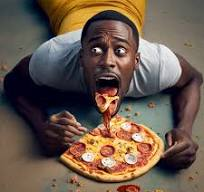

In [38]:
img_path=r"Food Images\pizza_steak_sushi\pizza.jpg"
img_pizza=Image.open(img_path)
img_pizza

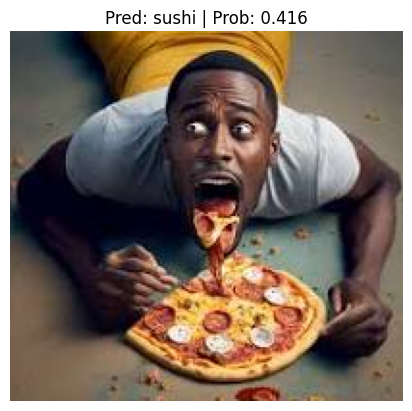

In [39]:
pred_and_plot_image(model=model,
                        image_path=img_path,
                        class_names=class_names,
                        # transform=weights.transforms(), # optionally pass in a specified transform from our pretrained model weights
                        image_size=(224, 224))

 Note; We given Pizza img to model, but model is predicting it as Sushi

 ### NOW I WILL MOVE THIS DATA IN ACTUAL TRAIN DATASET AND AGAIN TRAIN THE MODEL, THEN AGAIN CHECK THE PREDICATION

In [46]:
import os
import shutil

def move_image(image_path, target_folder):
    """Move an image to the target folder."""
    if not os.path.isfile(image_path):
        print(f"Image not found: {image_path}")
        return
    
    image_name = os.path.basename(image_path)
    target_path = os.path.join(target_folder, image_name)
    shutil.move(image_path, target_path)
    print(f"Moved {image_name} to {target_folder}")

def select_target_folder(base_folder, subfolders):
    """Return the target subfolder path based on user input."""
    print("Select the target folder:")
    for i, folder in enumerate(subfolders):
        print(f"{i + 1}. {folder}")

    target_index = int(input("Enter the number of the target folder: ")) - 1
    if target_index < 0 or target_index >= len(subfolders):
        print("Invalid selection.")
        return None

    return os.path.join(base_folder, subfolders[target_index])

def process_new_image_for_training(image_path):
    """Run the image moving process with the given image path."""

    base_folder = "Food Images/pizza_steak_sushi/train"
    subfolders= ["pizza", "steak", "sushi"]
    if not os.path.isfile(image_path):
        print("Invalid image path.")
        return
    
    target_folder = select_target_folder(base_folder, subfolders)
    if target_folder:
        move_image(image_path, target_folder)




Select the target folder:
1. pizza
2. steak
3. sushi
Moved pizza.jpg to Food Images/pizza_steak_sushi/train\pizza


#### function to move image to train dataset

In [66]:
image_path = "Food Images\pizza_steak_sushi\pizza1.jpg"  # Replace with your actual image path

# Call process_image in one line
process_new_image_for_training(image_path)

Select the target folder:
1. pizza
2. steak
3. sushi
Moved pizza1.jpg to Food Images/pizza_steak_sushi/train\pizza


#### Now, start trainig again

In [67]:
results = train_model(engine,
                      model,
                      train_dataloader,
                      test_dataloader,
                      optimizer,
                      loss_fn,
                      device, epochs=4)

 25%|██▌       | 1/4 [00:18<00:56, 18.86s/it]

Epoch: 1 | train_loss: 0.2428 | train_acc: 0.9766 | test_loss: 0.3689 | test_acc: 0.8665


 50%|█████     | 2/4 [00:37<00:36, 18.47s/it]

Epoch: 2 | train_loss: 0.2600 | train_acc: 0.9805 | test_loss: 0.3867 | test_acc: 0.8665


 75%|███████▌  | 3/4 [00:56<00:19, 19.07s/it]

Epoch: 3 | train_loss: 0.2266 | train_acc: 0.9805 | test_loss: 0.3685 | test_acc: 0.8665


100%|██████████| 4/4 [01:16<00:00, 19.15s/it]

Epoch: 4 | train_loss: 0.2166 | train_acc: 0.9844 | test_loss: 0.3443 | test_acc: 0.9072
[INFO] Total training time: 76.606 seconds


#### now, again save and load

In [69]:
save_model(model, model_save_path)
load_model(model, model_load_path)


Model saved to model_finetunned_efficientnet.pth
Model loaded from model_finetunned_efficientnet.pth


##### now again test on same img where model predicted wrong

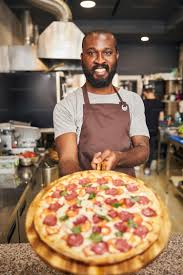

In [73]:
img_path=r"Food Images\pizza_steak_sushi\pizza2.jpg"
img_pizza=Image.open(img_path)
img_pizza

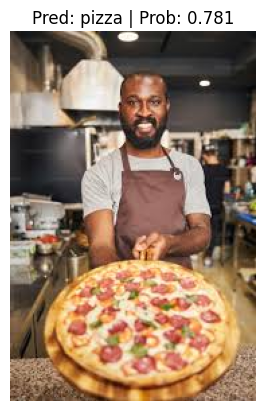

In [74]:
pred_and_plot_image(model=model,
                        image_path=img_path,
                        class_names=class_names,
                        # transform=weights.transforms(), # optionally pass in a specified transform from our pretrained model weights
                        image_size=(224, 224))

#### 3. I am predicting on another Steak image, let see model prediction

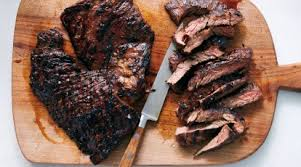

In [72]:
img_path=r"Food Images\pizza_steak_sushi\steak.jpg"
img_pizza=Image.open(img_path)
img_pizza

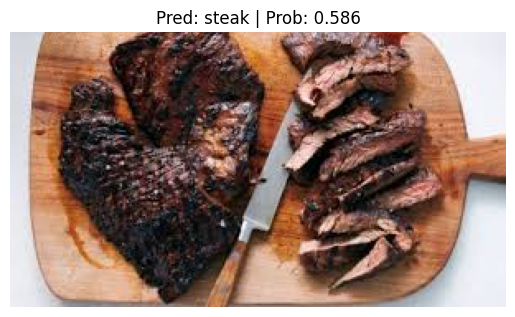

In [42]:
pred_and_plot_image(model=model,
                        image_path=img_path,
                        class_names=class_names,
                        # transform=weights.transforms(), # optionally pass in a specified transform from our pretrained model weights
                        image_size=(224, 224))

#### Note; We given Steak img to model, and model is predicting it as Steak